# explore data

## load data

In [1]:
#
import os
import random
from tqdm import tqdm

In [2]:
#%%
fuzzy_name_2_entity_name = dict()
with open("FB15k_mid2name.txt", "r") as f:
    for line in f:
        e_id, e_name = line.split()
        fuzzy_name_2_entity_name[e_id] = e_name

print(len(fuzzy_name_2_entity_name))

14951


In [3]:
random.choice(list(fuzzy_name_2_entity_name.items()))

('/m/0bjkk9', 'Nebraska_Cornhuskers_football')

In [4]:
#%%
id_2_entity_name = dict()
with open(os.path.join("benchmarks", "FB15K", "entity2id.txt"), "r") as f:
    for i, line in enumerate(f):
        if i != 0:
            e_name, e_id = line.split()
            id_2_entity_name[int(e_id)] = fuzzy_name_2_entity_name[e_name]

print(len(id_2_entity_name))

14951


In [5]:
random.choice(list(id_2_entity_name.items()))

(4756, 'Days_of_Being_Wild')

In [6]:
#%%
id_2_relation_name = dict()
with open(os.path.join("benchmarks", "FB15K", "relation2id.txt"), "r") as f:
    for i, line in enumerate(f):
        if i != 0:
            r_name, r_id = line.split()
            id_2_relation_name[int(r_id)] = r_name

print(len(id_2_relation_name))

1345


In [7]:
random.choice(list(id_2_relation_name.items()))

(958, '/religion/religion/is_part_of')

In [8]:
#%%
def string_format_triple(e1, e2, rel):
    e1_name = id_2_entity_name[e1]
    e2_name = id_2_entity_name[e2]
    r_name = id_2_relation_name[rel]
    return f"{e1_name}, {r_name}, {e2_name}"

In [9]:
#%%
train_triples = []
with open(os.path.join("benchmarks", "FB15K", "train2id.txt"), "r") as f:
    for i, line in enumerate(f):
        if i != 0:
            e1, e2, r = line.split()
            triple = (int(e1), int(e2), int(r))
            train_triples.append(triple)

print(len(train_triples))

483142


In [40]:
import pandas as pd

In [41]:
df_rows = []
for h,t,r in train_triples:
    df_rows.append({
        "h": str(h),
        "t": str(t),
        "r": str(r)
    })
triple_df = pd.DataFrame(df_rows)

In [42]:
import numpy as np

In [48]:
values, #%%
h_values, h_counts = np.unique(triple_df["h"].value_counts().values, return_counts=True)
# 出现i次(i个三元组)的不同头实体个数为appear_count_2_head_entity_count[i]，例如i为1，表明appear_count_2_head_entity_count[1]个实体只出现了一次
appear_count_2_head_entity_count = dict(zip(h_values, h_counts))
t_values, t_counts = np.unique(triple_df["t"].value_counts().values, return_counts=True)
appear_count_2_tail_entity_count = dict(zip(t_values, t_counts))
r_values, r_counts = np.unique(triple_df["r"].value_counts().values, return_counts=True)
appear_count_2_relation_count = dict(zip(r_values, r_counts))

In [44]:
import matplotlib.pyplot as plt

In [45]:
test_df = pd.DataFrame({"values": values, "counts": counts})

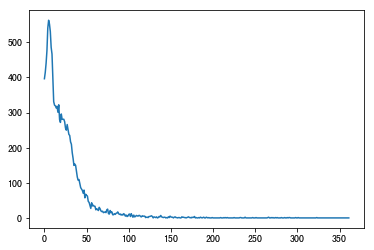

In [28]:
test_df["counts"].plot()

In [10]:
x = random.choice(train_triples)
print(x, string_format_triple(*x))

(3187, 3722, 140) Concord_Records, /music/record_label/artist, Sheila_E.


In [11]:
valid_triples = []
with open(os.path.join("benchmarks", "FB15K", "valid2id.txt"), "r") as f:
    for i, line in enumerate(f):
        if i != 0:
            e1, e2, r = line.split()
            triple = (int(e1), int(e2), int(r))
            valid_triples.append(triple)
            
print(len(valid_triples))

50000


In [82]:
x = random.choice(valid_triples)
print(x, string_format_triple(*x))

(403, 6855, 91) Topic_Webpage, /common/annotation_category/annotations./common/webpage/topic, Henry_Rollins


In [13]:
test_triples = []
with open(os.path.join("benchmarks", "FB15K", "test2id.txt"), "r") as f:
    for i, line in enumerate(f):
        if i != 0:
            e1, e2, r = line.split()
            triple = (int(e1), int(e2), int(r))
            test_triples.append(triple)
test_count = len(test_triples)            
print(test_count)

59071


In [14]:
x = random.choice(test_triples)
print(x, string_format_triple(*x))

(8037, 846, 40) University_of_Westminster, /education/educational_institution/students_graduates./education/education/student, Richard_Wright


In [15]:
set_triples_train = set(train_triples)

In [16]:
set_triples_train_valid = set(train_triples + valid_triples)

In [17]:
set_triples_train_valid_test = set(train_triples + valid_triples + test_triples)

## import to neo4j

In [18]:
from tqdm import tqdm
from py2neo import Graph

In [19]:
g = Graph(user="neo4j", password="hitales")

清空图：
MATCH (n) DETACH DELETE n

不过滤查询：
MATCH (n) RETURN n LIMIT 100

新建node（如果不存在）：
MERGE (e:Entity {name: 'Alice'}) 
ON CREATE SET e.name = "Alice"
RETURN e;

新建关系：
MATCH (h:Entity), (t:Entity)
WHERE h.name = 'Alice' AND t.name = 'Andy'
CREATE (h)-[r:Relation {name: 'isFriends'}]->(t)

找出有最多关系的尾实体:
MATCH ()-[r]->(n)
WITH n, count(r) as rel_cnt
WHERE rel_cnt > 1
RETURN n.name, rel_cnt ORDER BY rel_cnt DESC;

In [20]:
def create_entity_on_graph(entity_id):
    entity_name = id_2_entity_name[entity_id]
    # \是特殊字符
    entity_name = entity_name.replace("\\", "\\\\")
    entity_node_creation = f"CREATE (e:Entity {{name: \"{entity_name}\"}})"
    g.run(entity_node_creation)

In [21]:
def create_relation_on_graph(h, t, r):
    h_name = id_2_entity_name[h]
    h_name = h_name.replace("\\", "\\\\")
    t_name = id_2_entity_name[t]
    t_name = t_name.replace("\\", "\\\\")
    r_name = id_2_relation_name[r]
    r_name = r_name.replace("\\", "\\\\")
    relation_creation = f"MATCH (h:Entity), (t:Entity) WHERE h.name = \"{h_name}\" AND t.name = \"{t_name}\" CREATE (h)-[r:Relation {{name: \"{r_name}\"}}]->(t);"
    g.run(relation_creation)

x = random.choice(train_triples)
print(x, string_format_triple(*x))

create_entity_on_graph(1785)
create_entity_on_graph(11751)
create_relation_on_graph(1785, 11751, 105)

In [22]:
for entity_id in tqdm(id_2_entity_name):
    create_entity_on_graph(entity_id)

100%|██████████| 14951/14951 [00:36<00:00, 410.64it/s]


In [ ]:
for triple in tqdm(train_triples):
    create_relation_on_graph(*triple)

In [24]:
g.evaluate("MATCH (e:Entity) RETURN count(e)")

14951

In [ ]:
g.run("MATCH (n) RETURN n LIMIT 10").to_table()

## summarize

In [18]:
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable

In [19]:
entity_count = len(id_2_entity_name)
relation_count = len(id_2_relation_name)
train_count = len(train_triples)
batch_count = 100
batch_size = train_count//100
print(f"实体个数: {entity_count}, 关系个数: {relation_count}, 训练三元组个数: {train_count}, batch_size: {batch_size}")

实体个数: 14951, 关系个数: 1345, 训练三元组个数: 483142, batch_size: 4831


## get batch

In [90]:
import random

In [91]:
batch_size = train_count//100

In [92]:
def get_corrupt_head_triple(h, t, r, count, triples):
    """
    通过打乱head生成一个负样本
    """
    while True:
        new_h = random.randrange(count)
        # 过滤false negative的样本
        if new_h != h and (new_h, t, r) not in triples:
            break
    return (new_h, t, r)

def get_corrupt_tail_triple(h, t, r, count, triples):
    """
    通过打乱tail生成一个负样本
    """
    while True:
        new_t = random.randrange(count)
        if new_t != t and (h, new_t, r) not in triples:
            break
    return (h, new_t, r)

In [93]:
def get_batch_list(triple_list, num_batches):
    batch_size = len(triple_list) // num_batches
    batch_list = [0] * num_batches
    for i in range(num_batches - 1):
        batch_list[i] = triple_list[i * batch_size: (i + 1) * batch_size]
    batch_list[num_batches - 1] = triple_list[(num_batches - 1) * batch_size:]
    return batch_list

In [94]:
def get_batch_all(triple_list, entity_count, set_of_triples):
    negative_triple_list = [get_corrupt_head_triple(h, t, r, entity_count, set_of_triples) if random.random() < 0.5
                            else get_corrupt_tail_triple(h, t, r, entity_count, set_of_triples) for h, t, r in triple_list]
    pos_h = [h for h,_,_ in triple_list]
    pos_t = [t for _,t,_ in triple_list]
    pos_r = [r for _,_,r in triple_list]
    neg_h = [h for h,_,_ in negative_triple_list]
    neg_t = [t for _,t,_ in negative_triple_list]
    neg_r = [r for _,_,r in negative_triple_list]
    return np.array(pos_h), np.array(pos_t), np.array(pos_r), np.array(neg_h), np.array(neg_t), np.array(neg_r)

In [32]:
batch_list = train_triples[300:303]

In [33]:
for triple in batch_list:
    print(triple, string_format_triple(*triple))

(543, 544, 118) 1992_Winter_Olympics, /olympics/olympic_games/sports, Ice_Hockey
(545, 546, 143) Europe, /base/locations/continents/countries_within, Poland
(547, 548, 37) Fredric_March, /award/award_nominee/award_nominations./award/award_nomination/award, Tony_Award_for_Best_Actor_in_a_Play


In [34]:
p_h, p_t, p_r, n_h, n_t, n_r = get_batch_all(batch_list, entity_count, set_triples_train)

In [38]:
print(f"p_h: {p_h}")
print(f"p_t: {p_t}")
print(f"p_r: {p_r}")
print(f"n_h: {n_h}")
print(f"n_t: {n_t}")
print(f"n_r: {n_r}")

p_h: [543 545 547]
p_t: [544 546 548]
p_r: [118 143  37]
n_h: [  543 11926  9398]
n_t: [11031   546   548]
n_r: [118 143  37]


In [35]:
for h, t, r in zip(p_h, p_t, p_r):
    print(string_format_triple(h, t, r), "正样本")

1992_Winter_Olympics, /olympics/olympic_games/sports, Ice_Hockey 正样本
Europe, /base/locations/continents/countries_within, Poland 正样本
Fredric_March, /award/award_nominee/award_nominations./award/award_nomination/award, Tony_Award_for_Best_Actor_in_a_Play 正样本


In [36]:
for h, t, r in zip(n_h, n_t, n_r):
    print(string_format_triple(h, t, r), "负样本")

1992_Winter_Olympics, /olympics/olympic_games/sports, North_Atlantic_Treaty_Organization_(NATO) 负样本
Russian_American, /base/locations/continents/countries_within, Poland 负样本
Jared_Leto, /award/award_nominee/award_nominations./award/award_nomination/award, Tony_Award_for_Best_Actor_in_a_Play 负样本


In [37]:
def get_batch_random(triple_list, batch_size, entity_count, set_of_triples):
    batch_triple_list = random.sample(triple_list, batch_size)
    negative_triple_list = [get_corrupt_head_triple(h, t, r, entity_count, set_of_triples) if random.random() < 0.5
                            else get_corrupt_tail_triple(h, t, r, entity_count, set_of_triples) for h, t, r in batch_triple_list]
    pos_h = [h for h,_,_ in batch_triple_list]
    pos_t = [t for _,t,_ in batch_triple_list]
    pos_r = [r for _,_,r in batch_triple_list]
    neg_h = [h for h,_,_ in negative_triple_list]
    neg_t = [t for _,t,_ in negative_triple_list]
    neg_r = [r for _,_,r in negative_triple_list]
    return np.array(pos_h), np.array(pos_t), np.array(pos_r), np.array(neg_h), np.array(neg_t), np.array(neg_r)

# define model

In [20]:
class TransE(nn.Module):
    def __init__(self, entity_count, relation_count, embedding_dimension):
        super(TransE, self).__init__()
        # 实体embedding
        self._ent_embeddings = nn.Embedding(entity_count, embedding_dimension)
        # 关系embedding
        self._rel_embeddings = nn.Embedding(relation_count, embedding_dimension)
        # weight初始化
        nn.init.xavier_uniform_(self._ent_embeddings.weight.data)
        nn.init.xavier_uniform_(self._ent_embeddings.weight.data)
        
    def _scoring_function(self, h, t, r):
        """
        fr(h, t, r)
        """
        # 按元素求绝对值
        s = -torch.abs(h + r - t) # L1 distance
        # s = -((h + r - t) ** 2) # L2 distance
        s = torch.sum(s, 1)
        return s
    
    def _norm_regularization_loss(self, embeddings, dim=1):
        """
        L2 regularization
        """
        norm = torch.sum(embeddings ** 2, dim=dim, keepdim=True)
        return torch.sum(torch.max(norm - Variable(torch.FloatTensor([1.0])), Variable(torch.FloatTensor([0.0]))))
        
    def forward(self, pos_batch_h, pos_batch_t, pos_batch_r, neg_batch_h, neg_batch_t, neg_batch_r):
        """
        示例三元组：(1,5,8), (2,6,9), (3,7,10)
        :param pos_batch_h: np.array([1,2,3]) 正样本对应的h实体列表
        :param pos_batch_t: np.array([5,6,7]) 正样本对应的t实体列表
        :param pos_batch_r: np.array([8,9,10]) 正样本对应的r关系列表
        :param neg_batch_h: 负样本。。。
        :param neg_batch_t:
        :param neg_batch_r:
        """
        # pos_, p_ => 正样本, neg_, n_ => 负样本
        pos_h = Variable(torch.from_numpy(pos_batch_h))
        pos_t = Variable(torch.from_numpy(pos_batch_t))
        pos_r = Variable(torch.from_numpy(pos_batch_r))
        neg_h = Variable(torch.from_numpy(neg_batch_h))
        neg_t = Variable(torch.from_numpy(neg_batch_t))
        neg_r = Variable(torch.from_numpy(neg_batch_r))
        p_h = self._ent_embeddings(pos_h)
        p_t = self._ent_embeddings(pos_t)
        p_r = self._rel_embeddings(pos_r)
        n_h = self._ent_embeddings(neg_h)
        n_t = self._ent_embeddings(neg_t)
        n_r = self._rel_embeddings(neg_r)
        p_score = self._scoring_function(p_h, p_t, p_r)
        n_score = self._scoring_function(n_h, n_t, n_r)
        # https://pytorch.org/docs/stable/nn.html#torch.nn.MarginRankingLoss
        criterion = nn.MarginRankingLoss(1, False) # False 意味一个batch中的多个样本loss求和
        y = Variable(torch.Tensor([1])) # y为1，正样本对应分数更高
        loss = criterion(p_score, n_score, y)
        # 下面这个是给loss加上L2 reg term
        # ent_embeddings = self._ent_embeddings(torch.cat([pos_h, pos_t, neg_h, neg_t]))
        # rel_embeddings = self._rel_embeddings(torch.cat([pos_r, neg_r]))
        # loss = loss + self._norm_regularization_loss(ent_embeddings) + self._norm_regularization_loss(rel_embeddings)
        return loss
    
    def predict(self, h, t, r):
        """
        注意，得出的fr(h, t, r) score
        """
        p_h = self._ent_embeddings(Variable(torch.from_numpy(h)))
        p_t = self._ent_embeddings(Variable(torch.from_numpy(t)))
        p_r = self._rel_embeddings(Variable(torch.from_numpy(r)))
        return self._scoring_function(p_h, p_t, p_r)  

## model loss demo

In [40]:
demo_entity_count = 3
demo_relation_count = 4
demo_embedding_dimension = 5
demo_ent_embeddings = nn.Embedding(demo_entity_count, demo_embedding_dimension)
demo_rel_embeddings = nn.Embedding(demo_relation_count, demo_embedding_dimension)
nn.init.xavier_uniform_(demo_ent_embeddings.weight.data)
nn.init.xavier_uniform_(demo_rel_embeddings.weight.data)

tensor([[-0.1273,  0.2170,  0.7699,  0.6952,  0.1699],
        [-0.6160,  0.4615,  0.3355,  0.6024,  0.5683],
        [ 0.3537, -0.4161,  0.8021, -0.3998, -0.8053],
        [-0.0591,  0.1567,  0.7029, -0.8015,  0.4734]])

In [41]:
demo_ent_embeddings.weight.data

tensor([[ 0.1263, -0.5359, -0.6048,  0.0355, -0.4541],
        [ 0.1900, -0.3014,  0.1206,  0.6039,  0.7024],
        [ 0.6603, -0.3395, -0.7639,  0.8320,  0.7146]])

In [42]:
demo_ent_embeddings.weight.shape

torch.Size([3, 5])

In [43]:
demo_rel_embeddings.weight.data

tensor([[-0.1273,  0.2170,  0.7699,  0.6952,  0.1699],
        [-0.6160,  0.4615,  0.3355,  0.6024,  0.5683],
        [ 0.3537, -0.4161,  0.8021, -0.3998, -0.8053],
        [-0.0591,  0.1567,  0.7029, -0.8015,  0.4734]])

In [44]:
demo_rel_embeddings.weight.shape

torch.Size([4, 5])

In [45]:
demo_pos_batch_h = np.array([1,2])
demo_pos_batch_t = np.array([0,1])
demo_pos_batch_r = np.array([3,2])
demo_neg_batch_h = np.array([1,2])
demo_neg_batch_t = np.array([2,0])
demo_neg_batch_r = np.array([3,2])

In [46]:
demo_pos_h = Variable(torch.from_numpy(demo_pos_batch_h))
demo_pos_t = Variable(torch.from_numpy(demo_pos_batch_t))
demo_pos_r = Variable(torch.from_numpy(demo_pos_batch_r))
demo_neg_h = Variable(torch.from_numpy(demo_neg_batch_h))
demo_neg_t = Variable(torch.from_numpy(demo_neg_batch_t))
demo_neg_r = Variable(torch.from_numpy(demo_neg_batch_r))

In [48]:
demo_p_h = demo_ent_embeddings(demo_pos_h)
demo_p_t = demo_ent_embeddings(demo_pos_t)
demo_p_r = demo_rel_embeddings(demo_pos_r)
demo_n_h = demo_ent_embeddings(demo_neg_h)
demo_n_t = demo_ent_embeddings(demo_neg_t)
demo_n_r = demo_rel_embeddings(demo_neg_r)

In [49]:
print(f"demo_p_h: {demo_p_h}")
print(f"demo_p_t: {demo_p_t}")
print(f"demo_p_r: {demo_p_r}")
print(f"demo_n_h: {demo_n_h}")
print(f"demo_n_t: {demo_n_t}")
print(f"demo_n_r: {demo_n_r}")

demo_p_h: tensor([[ 0.1900, -0.3014,  0.1206,  0.6039,  0.7024],
        [ 0.6603, -0.3395, -0.7639,  0.8320,  0.7146]])
demo_p_t: tensor([[ 0.1263, -0.5359, -0.6048,  0.0355, -0.4541],
        [ 0.1900, -0.3014,  0.1206,  0.6039,  0.7024]])
demo_p_r: tensor([[-0.0591,  0.1567,  0.7029, -0.8015,  0.4734],
        [ 0.3537, -0.4161,  0.8021, -0.3998, -0.8053]])
demo_n_h: tensor([[ 0.1900, -0.3014,  0.1206,  0.6039,  0.7024],
        [ 0.6603, -0.3395, -0.7639,  0.8320,  0.7146]])
demo_n_t: tensor([[ 0.6603, -0.3395, -0.7639,  0.8320,  0.7146],
        [ 0.1263, -0.5359, -0.6048,  0.0355, -0.4541]])
demo_n_r: tensor([[-0.0591,  0.1567,  0.7029, -0.8015,  0.4734],
        [ 0.3537, -0.4161,  0.8021, -0.3998, -0.8053]])


In [50]:
demo_p_score = -torch.abs(demo_p_h + demo_p_r - demo_p_t) 

In [51]:
demo_p_score

tensor([[-0.0046, -0.3913, -1.4283, -0.2332, -1.6299],
        [-0.8240, -0.4541, -0.0824, -0.1716, -0.7931]])

In [52]:
demo_p_score = torch.sum(demo_p_score, 1)

In [53]:
demo_p_score
# 两个样本，之后通过margin loss function求和

tensor([-3.6872, -2.3253])

In [54]:
demo_n_score = -torch.abs(demo_n_h + demo_n_r - demo_n_t) 

In [55]:
demo_n_score

tensor([[-0.5295, -0.1948, -1.5874, -1.0296, -0.4612],
        [-0.8877, -0.2196, -0.6430, -0.3967, -0.3634]])

In [56]:
demo_n_score = torch.sum(demo_n_score, 1)

In [57]:
demo_n_score

tensor([-3.8026, -2.5104])

In [58]:
criterion = nn.MarginRankingLoss(1, False)
y = Variable(torch.Tensor([1])) 
loss = criterion(demo_p_score, demo_n_score, y)

In [59]:
loss

tensor(1.6996)

In [60]:
# 下面演示OpenKE实现的等价性

In [61]:
_openke_p_score = torch.abs(demo_p_h + demo_p_r - demo_p_t)
_openke_n_score = torch.abs(demo_n_h + demo_n_r - demo_n_t)

In [62]:
_openke_p_score

tensor([[ 0.0046,  0.3913,  1.4283,  0.2332,  1.6299],
        [ 0.8240,  0.4541,  0.0824,  0.1716,  0.7931]])

In [63]:
_openke_n_score

tensor([[ 0.5295,  0.1948,  1.5874,  1.0296,  0.4612],
        [ 0.8877,  0.2196,  0.6430,  0.3967,  0.3634]])

In [64]:
_openke_p_score = _openke_p_score.view(-1, 1, demo_embedding_dimension)
_openke_n_score = _openke_n_score.view(-1, 1, demo_embedding_dimension)
_openke_p_score = torch.sum(torch.mean(_openke_p_score, 1), 1)
_openke_n_score = torch.sum(torch.mean(_openke_n_score, 1), 1)

In [65]:
_openke_p_score

tensor([ 3.6872,  2.3253])

In [66]:
_openke_n_score

tensor([ 3.8026,  2.5104])

In [67]:
criterion = nn.MarginRankingLoss(1, False)
y = Variable(torch.Tensor([-1]))
openke_loss = criterion(_openke_p_score, _openke_n_score, y)

In [68]:
openke_loss

tensor(1.6996)

# train model

In [69]:
from tqdm import tqdm

In [70]:
model = TransE(entity_count, relation_count, 100)

In [71]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [72]:
train_batch_list = get_batch_list(train_triples, batch_count)

In [73]:
number_of_epoch = 1000

In [ ]:
train_losses = []
valid_losses = []
for epoch in tqdm(range(number_of_epoch)):
    total_loss = 0.0
    random.shuffle(train_batch_list)
    for batch_triples in train_batch_list:
        p_h, p_t, p_r, n_h, n_t, n_r = get_batch_all(batch_triples, entity_count, set_triples_train)
        
        optimizer.zero_grad()
        # 前向
        loss = model(p_h, p_t, p_r, n_h, n_t, n_r)
        total_loss = total_loss + loss.item()
        # 求梯度
        loss.backward()
        # 梯度下降
        optimizer.step()
    print(f"{epoch}, train {total_loss}")
    train_losses.append(total_loss)
    
    if epoch%10 == 0:
        p_h, p_t, p_r, n_h, n_t, n_r = get_batch_random(valid_triples, batch_size, entity_count, set_triples_train_valid)
        loss = model(p_h, p_t, p_r, n_h, n_t, n_r)
        print(f"{epoch}, valid {loss.item()}")
        valid_losses.append(loss.item())

# save model

In [ ]:
torch.save(model.state_dict(), "transe_fb15k.pt")

# load model

In [21]:
model = TransE(entity_count, relation_count, 100)
model.load_state_dict(torch.load("res/transe_fb15k.pt"))

# test model

# test link prediction

In [192]:
def get_candidate_answer_for_head(t, r, count):
    p_h = np.arange(count)
    p_t = np.full(count, t)
    p_r = np.full(count, r)
    return np.array(p_h), np.array(p_t), np.array(p_r)

def get_candidate_answer_for_tail(h, r, count):
    p_h = np.full(count, h)
    p_t = np.arange(count)
    p_r = np.full(count, r)
    return np.array(p_h), np.array(p_t), np.array(p_r)

In [193]:
get_candidate_answer_for_head(1, 2, 10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [77]:
get_candidate_answer_for_tail(1, 2, 5)

(array([1, 1, 1, 1, 1]), array([0, 1, 2, 3, 4]), array([2, 2, 2, 2, 2]))

In [78]:
from tqdm import tqdm

In [ ]:
l_tot = 0 # head命中前10
l_filter_tot = 0 # 过滤已知三元组之后head命中前10
l3_tot = 0 # head命中前3
l3_filter_tot = 0 # 过滤已知三元组之后head命中前3
l1_tot = 0 # head命中前1
l1_filter_tot = 0 # 过滤已知三元组之后head命中前1

l_rank = 0 # head命中的rank之和，为了计算MR
l_filter_rank = 0 # 过滤已知三元组之后head命中的rank之和
l_reci_rank = 0 # head命中的rank倒数之和，为了计算MRR
l_filter_reci_rank = 0 # 过滤已知三元组之后head命中的rank倒数之和

# 以下变量用于tail指标计算
r_tot = 0
r_filter_tot = 0
r3_tot = 0
r3_filter_tot = 0
r1_tot = 0
r1_filter_tot = 0

r_rank = 0
r_filter_rank = 0
r_reci_rank = 0
r_filter_reci_rank = 0

for test_triple in tqdm(test_triples):
    h, t, r = test_triple
    
    p_h, p_t, p_r = get_candidate_answer_for_head(t, r, entity_count)
    scores = model.predict(p_h, p_t, p_r)
    
    triple_score = scores[h]
    l_s = 0
    l_filter_s = 0
    for entity_id in range(entity_count):
        if entity_id != h:
            score = scores[entity_id]
            if score > triple_score:
                l_s += 1
                if (entity_id, t, r) not in set_triples_train_valid:
                    l_filter_s += 1
    if l_s < 10:
        l_tot += 1
    if l_filter_s < 10:
        l_filter_tot += 1
    if l_s < 3:
        l3_tot += 1
    if l_filter_s < 3:
        l3_filter_tot += 1
    if l_s < 1:
        l1_tot += 1
    if l_filter_s < 1:
        l1_filter_tot += 1
    
    l_rank += (1+l_s)  # 1+l_s即当前head的rank
    l_filter_rank += (1+l_filter_s)
    l_reci_rank += 1/(1+l_s)
    l_filter_reci_rank += 1/(1+l_filter_s)
    
    p_h, p_t, p_r = get_candidate_answer_for_tail(h, r, entity_count)
    scores = model.predict(p_h, p_t, p_r)
    
    triple_score = scores[t]
    r_s = 0
    r_filter_s = 0
    for entity_id in range(entity_count):
        if entity_id != t:
            score = scores[entity_id]
            if score > triple_score:
                r_s += 1
                if (h, entity_id, r) not in set_triples_train_valid:
                    r_filter_s += 1
    if r_s < 10:
        r_tot += 1
    if r_filter_s < 10:
        r_filter_tot += 1
    if r_s < 3:
        r3_tot += 1
    if r_filter_s < 3:
        r3_filter_tot += 1
    if r_s < 1:
        r1_tot += 1
    if r_filter_s < 1:
        r1_filter_tot += 1
        
    r_rank += (1+r_s)
    r_filter_rank += (1+r_filter_s)
    r_reci_rank += 1/(1+r_s)
    r_filter_reci_rank += 1/(1+r_filter_s)

In [ ]:
l_mr = l_rank / test_count
r_mr = r_rank / test_count
l_mrr = l_reci_rank / test_count
r_mrr = r_reci_rank / test_count
lp_hit10 = l_tot / test_count
rp_hit10 = r_tot / test_count
lp_hit3 = l3_tot / test_count
rp_hit3 = r3_tot / test_count
lp_hit1 = l1_tot / test_count
rp_hit1 = r1_tot / test_count

filter_l_mr = l_filter_rank / test_count
filter_r_mr = r_filter_rank / test_count
filter_l_mrr = l_filter_reci_rank / test_count
filter_r_mrr = r_filter_reci_rank / test_count
filter_lp_hit10 = l_filter_tot / test_count
filter_rp_hit10 = r_filter_tot / test_count
filter_lp_hit3 = l3_filter_tot / test_count
filter_rp_hit3 = r3_filter_tot / test_count
filter_lp_hit1 = l1_filter_tot / test_count
filter_rp_hit1 = r1_filter_tot / test_count

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame({
    "metric": ["predict head", "predict tail", "average", "predict head(filter)", "predict tail(filter)", "average(filter)"],
    "MRR": [l_mrr, r_mrr, (l_mrr+r_mrr)/2, filter_l_mrr, filter_r_mrr, (filter_l_mrr+filter_r_mrr)/2],
    "MR": [l_mr, r_mr, (l_mr+r_mr)/2, filter_l_mr, filter_r_mr, (filter_l_mr+filter_r_mr)/2],
    "P@10": [lp_hit10, rp_hit10, (lp_hit10+rp_hit10)/2, filter_lp_hit10, filter_rp_hit10, (filter_lp_hit10+filter_rp_hit10)/2],
    "P@3": [lp_hit3, rp_hit3, (lp_hit3+rp_hit3)/2, filter_lp_hit3, filter_rp_hit3, (filter_lp_hit3+filter_rp_hit3)/2],
    "P@1": [lp_hit1, rp_hit1, (lp_hit1+rp_hit1)/2, filter_lp_hit1, filter_rp_hit1, (filter_lp_hit1+filter_rp_hit1)/2]
})

In [57]:
import numpy as np
def predict_head_entity(t, r, k):
    """
    :param t: 尾实体id
    :param r: 关系id
    :param k: top k
    """
    test_h = np.array(range(entity_count))
    test_r = np.array([r] * entity_count)
    test_t = np.array([t] * entity_count)
    scores = model.predict(test_h, test_t, test_r)
    result = scores.data.numpy().reshape(-1).argsort()[-k:]
    return result

In [58]:
def find_entity_id_by_entity_name(n):
    for e_id, e_name in id_2_entity_name.items():
        if e_name == n:
            return e_id
    return None

In [102]:
def find_relation_id_by_relation_name(r):
    for r_id, r_name in id_2_relation_name.items():
        if r_name == r:
            return r_id
    return None

In [178]:
t = find_entity_id_by_entity_name("China")
r = find_relation_id_by_relation_name("/people/person/nationality")

In [179]:
t, r

(3381, 84)

In [180]:
hs = predict_head_entity(t, r, 10)

In [181]:
hs

array([ 1622,  3024, 12023,  2332,  9905,  2722, 10393,  9836, 11838,
        9136])

In [182]:
[id_2_entity_name[h] for h in hs]

['William_Chang',
 'Zhang_Ziyi',
 'Eric_Tsang',
 'Joan_Chen',
 'Chow_Yun-Fat',
 'Andy_Lau',
 'Daniel_Wu',
 'Jet_Li',
 'Tony_Leung_Chiu_Wai',
 'Sammo_Hung']

In [184]:
[(h,t,r) in set_triples_train_valid_test for h in hs] # False表示在训练集，验证集和测试集中不存在的三元组

[True, True, True, True, True, True, False, True, True, True]

# test triple classification

In [95]:
p_h, p_t, p_r, n_h, n_t, n_r = get_batch_all(valid_triples, entity_count, set_triples_train_valid)
p_scores = model.predict(p_h, p_t, p_r)
n_scores = model.predict(n_h, n_t, n_r)
p_scores = p_scores.cpu().data.numpy() # tensor to numpy
n_scores = n_scores.cpu().data.numpy()

In [96]:
from collections import defaultdict
# 关系id => 验证样本下标列表，之后可以由此p_scores和n_scores中找到对应该id的所有score
relation_triple_indexes = defaultdict(list)
for i, triple in enumerate(valid_triples):
    _, _, r = triple
    relation_triple_indexes[r].append(i)
relation_triple_indexes = dict(relation_triple_indexes)

In [97]:
def get_best_thresholds(relation_triple_indexes, relation_count, p_scores, n_scores):
    try_interval = 0.01
    best_thresholds_for_relation = np.zeros(relation_count)
    for relation_id in range(relation_count):
        if relation_id not in relation_triple_indexes:
            continue
        relation_p_scores = [p_scores[i] for i in relation_triple_indexes[relation_id]]
        relation_n_scores = [n_scores[i] for i in relation_triple_indexes[relation_id]]
        relation_all_scores = relation_p_scores + relation_n_scores
        max_score = max(relation_all_scores)
        min_score = min(relation_all_scores)
        
        # 根据这个关系id对应的score范围，以0.01为粒度，尝试找到准确率最高的阈值
        best_correct_count = 0
        best_threshold = 0
        for threshold in np.arange(min_score, max_score, try_interval):
            correct_count = 0
            for i in relation_triple_indexes[relation_id]:
                if p_scores[i] >= threshold:
                    correct_count += 1
                if n_scores[i] < threshold:
                    correct_count += 1
            if correct_count > best_correct_count:
                best_threshold = threshold
                best_correct_count = correct_count
        best_thresholds_for_relation[relation_id] = best_threshold
    return best_thresholds_for_relation

In [98]:
best_thresholds_for_relation = get_best_thresholds(relation_triple_indexes, relation_count, p_scores, n_scores)

In [99]:
p_h, p_t, p_r, n_h, n_t, n_r = get_batch_all(test_triples, entity_count, set_triples_train_valid_test)
p_scores = model.predict(p_h, p_t, p_r)
n_scores = model.predict(n_h, n_t, n_r)
p_scores = p_scores.cpu().data.numpy()
n_scores = n_scores.cpu().data.numpy()

In [100]:
correct_count = 0
total_count = 0
for i,triple in enumerate(test_triples):
    _,_,r = triple
    # 如果valid中没有对应r的样本，则无法测试...
    if r not in relation_triple_indexes:
        continue
    threshold = best_thresholds_for_relation[r]
    total_count += 2 # 因为实际上还有一倍的负样本
    if p_scores[i] >= threshold:
        correct_count += 1
    if n_scores[i] < threshold:
        correct_count += 1
        
acc = correct_count / total_count
print(f"triple classification accuracy: {acc}")

triple classification accuracy: 0.9643197036130655


In [118]:
def predict_triple(h, t, r):
    score = model.predict(np.array([h]), np.array([t]), np.array([r])).data.numpy()
    best_threshold = best_thresholds_for_relation[r]
    if score > best_threshold:
        return True
    else:
        return False

In [198]:
h = find_entity_id_by_entity_name("China")
t = find_entity_id_by_entity_name("Tsinghua_University")
t = find_entity_id_by_entity_name("University_of_Tokyo")
t = find_entity_id_by_entity_name("University_of_North_Texas")
r = find_relation_id_by_relation_name("/location/location/contains")

In [199]:
string_format_triple(h, t, r)

'China, /location/location/contains, University_of_North_Texas'

In [200]:
(h, t, r) in set_triples_train_valid_test

False

In [201]:
predict_triple(h, t, r)

False